In [34]:
import os
from data_generator3V2 import Data_generator, generate_dates, convert_date_format, \
                            load_standardization_data
from models.attention_res_net3V2_noAtt import Att_Res_UNet

import tensorflow as tf
import time
import pickle
# import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import abfile
from netCDF4 import Dataset
from scipy.spatial import cKDTree
%matplotlib
%load_ext autoreload

import re

def extract_name_and_number(input_string):
    # Define a pattern for the desired format
    pattern = re.compile(r'^(.+)-(layer|cat)-(\d+)$')

    # Match the pattern against the input string
    match = pattern.match(input_string)

    # Check if the pattern matches
    if match:
        # Extract the name and number from the matched groups
        name = match.group(1)
        number = match.group(3)
        return name, number
    else:
        # Return None if the input string doesn't match the expected format
        return None, None

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
%load_ext autoreload

def plot_fld(vname,fld,max_abs_val = None, min_abs_val = None):
    f, (ax1) = plt.subplots(1, 1, figsize=(11, 11))
    if (max_abs_val is None) and (min_abs_val is None):
        max_abs_val = np.max(fld)
        min_abs_val = np.min(fld)       
    P=ax1.pcolormesh(fld, vmin=min_abs_val, vmax=max_abs_val) ; plt.colorbar(P,ax=ax1); ax1.set_title(vname);

cmap = plt.cm.get_cmap("bwr").copy()
cmap.set_bad('gray')
def plot_res(vname,fld,max_abs_val = None) :
    f, (ax1) = plt.subplots(1, 1, figsize=(10, 8))
    if max_abs_val is None:
        max_abs_val = np.max(np.abs(fld))
    P = ax1.pcolormesh(fld, cmap=cmap, vmin=-max_abs_val, vmax=max_abs_val) ; plt.colorbar(P,ax=ax1); ax1.set_title(vname);

Using matplotlib backend: agg
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Check Python version
import sys
print("Python version:", sys.version)

# Check TensorFlow version
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


Python version: 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]
TensorFlow version: 2.8.0


In [2]:
experiment_name = "Attention_Res_UNet"

date_min_test = '2015_004'
date_max_test = '2015_361'
#date_min_test = '2019_074'
#date_max_test = '2019_095'

days_range = 7 # number of days between two restart
dates_test = generate_dates(date_min_test, date_max_test, days_range)
print('date list of testing days:')
print(dates_test)
print(f'number of testing days: {len(dates_test)}')
#

paths = {}
root_data_dir = '/mnt/redda-ns2993k/Antoine/Betzy/data'
root_output_dir = 'outputs'

paths["data_residuals"] = os.path.join(root_data_dir,"residuals")
paths["data_LR_upsampled"] = os.path.join(root_data_dir,"LR_upsampled")

paths["forcings"] = root_data_dir
paths["standard"] = root_data_dir
paths["outputs"] = root_output_dir
paths["model_weights"] = os.path.join(root_output_dir,"Model_weights",experiment_name)
paths["checkpoints"] = os.path.join(root_output_dir,"Model_weights",experiment_name,"Checkpoints")

#
file_standardization_LR_upsampled = os.path.join(paths["standard"],"standard_LR_upsampled.h5")
file_standardization_res = os.path.join(paths["standard"],"standard_residuals.h5")
file_checkpoints = os.path.join(paths["checkpoints"],"Checkpoints.h5")
file_standardization_bathy = os.path.join(paths["standard"],"standard_bathy_HR.h5")
file_standardization_ssh_LR_upsampled = os.path.join(paths["standard"],"standard_ssh_LR_upsampled.h5")
file_standardization_forcings = os.path.join(paths["standard"],"standard_forcings.h5")

file_model_training_history = os.path.join('outputs/',f"Training_history.pkl")

#file_checkpoints = os.path.join(paths["checkpoints"],"Checkpoints.h5")
file_model_weights = os.path.join(paths["checkpoints"],"Checkpoints.h5")

date list of testing days:
['2015_004', '2015_011', '2015_018', '2015_025', '2015_032', '2015_039', '2015_046', '2015_053', '2015_060', '2015_067', '2015_074', '2015_081', '2015_088', '2015_095', '2015_102', '2015_109', '2015_116', '2015_123', '2015_130', '2015_137', '2015_144', '2015_151', '2015_158', '2015_165', '2015_172', '2015_179', '2015_186', '2015_193', '2015_200', '2015_207', '2015_214', '2015_221', '2015_228', '2015_235', '2015_242', '2015_249', '2015_256', '2015_263', '2015_270', '2015_277', '2015_284', '2015_291', '2015_298', '2015_305', '2015_312', '2015_319', '2015_326', '2015_333', '2015_340', '2015_347', '2015_354', '2015_361']
number of testing days: 52


In [17]:
standard_LR_upsampled = load_standardization_data(file_standardization_LR_upsampled)
standard_res = load_standardization_data(file_standardization_res)
standard_bathy = load_standardization_data(file_standardization_bathy)
standard_ssh_LR_upsampled = load_standardization_data(file_standardization_ssh_LR_upsampled)
standard_forcings = load_standardization_data(file_standardization_forcings)


list_predictors = ["temp-layer-1","temp-layer-2","temp-layer-3","temp-layer-4","temp-layer-5", \
                   "temp-layer-6","temp-layer-7","temp-layer-8","temp-layer-9","temp-layer-10", \
                   "saln-layer-1","saln-layer-2","saln-layer-3","saln-layer-4","saln-layer-5", \
                   "saln-layer-6","saln-layer-7","saln-layer-8","saln-layer-9","saln-layer-10", \
                   "u-layer-1","u-layer-2","u-layer-3","u-layer-4","u-layer-5", \
                   "u-layer-6","u-layer-7","u-layer-8","u-layer-9","u-layer-10", \
                   "v-layer-1","v-layer-2","v-layer-3","v-layer-4","v-layer-5", \
                   "v-layer-6","v-layer-7","v-layer-8","v-layer-9","v-layer-10", \
                   "ubavg-layer-0", "vbavg-layer-0", \
                   "tp5_bathy", "tp5_mask"]

list_predictors = ["v-layer-1","v-layer-2","v-layer-3","v-layer-4","v-layer-5", \
                "v-layer-6","v-layer-7","v-layer-8","v-layer-9","v-layer-10", \
                "tp5_mask"]
list_targets = ["v-layer-1"]

list_predictors = ["u-layer-1","u-layer-2","u-layer-3","u-layer-4","u-layer-5", \
                   "u-layer-6","u-layer-7","u-layer-8","u-layer-9","u-layer-10", \
                   "tp5_mask","tp5_bathy","ssh_upsampled"]
list_targets = ["u-layer-1"]

list_predictors = ["temp-layer-1", "temp-layer-2", "temp-layer-3", "temp-layer-4", "temp-layer-5",
                    "temp-layer-6", "temp-layer-7", "temp-layer-8", "temp-layer-9", "temp-layer-10",
                    "tp5_mask"]
list_targets = ["temp-layer-1"]
#
model_params = {"list_predictors": list_predictors,
                "list_targets": list_targets, 
                "dim": (760, 800), # (jdm,idm)
                "cropped_dim": (768, 800), #
                "batch_size": 4,
                "n_filters": [32*(i+1) for i in range(6)], #Ref Cyril: 32
                "activation": "relu",
                "kernel_initializer": "he_normal",
                "batch_norm": True,
                "pooling_type": "Average",
                "dropout": 0,
               }
#
params_test = {"list_predictors": model_params["list_predictors"],
                "list_labels": model_params["list_targets"],
                "list_dates": dates_test,
                "standard_forcings": standard_forcings,
                "standard_res": standard_res,
                "standard_LR_upsampled": standard_LR_upsampled,
                "standard_bathy": standard_bathy,
                "standard_ssh_LR_upsampled": standard_ssh_LR_upsampled,
                "batch_size": model_params["batch_size"],
                "path_forcings": paths["forcings"],
                "path_data_res": paths["data_residuals"],
                "path_data_LR_upsampled": paths["data_LR_upsampled"],
                "dim": model_params["dim"],
                "cropped_dim": model_params["cropped_dim"],
                "shuffle": False,
                "res_normalization":1,
                }
#
model_and_compile_params = {**model_params, **params_test}

In [18]:
test_generator = Data_generator(**params_test)
unet_model = Att_Res_UNet(**model_params).make_unet_model()
unet_model.summary()

Model: "Res-att-U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 800, 1  0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 768, 800, 32  3200        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 768, 800, 32  128        ['conv2d_33[0][0]']              
 ormalization)                  )                                                     

In [19]:
unet_model.load_weights(file_model_weights)
predict_batch = unet_model.predict(test_generator[0][0]) # prediction on test_generator['batch_number']['LR field upsampled']

In [20]:
target_no = 0
target_name, target_layer = extract_name_and_number(list_targets[target_no])
target_layer = int(target_layer)
predict = predict_batch[0,:,:,target_no]
print(predict_batch.shape)
print(predict.shape)
predict = predict[0:760,:]

(4, 768, 800, 1)
(768, 800)


In [21]:
X_batch, y_batch = test_generator[0] ## True data
print('X_batch shape', X_batch.shape)
print('y_batch shape', y_batch.shape)
X = X_batch[0,...,target_no] ## first 0 -> sample number in the batch ... last 0 -> predictor number
y = y_batch[0,...,target_no]
print('X shape before crop', X.shape)
print('y shape before crop', y.shape)
X = X[0:760,:]
y = y[0:760,:]
print('X shape', X.shape)
print('y shape', y.shape)

X_batch shape (4, 768, 800, 11)
y_batch shape (4, 768, 800, 1)
X shape before crop (768, 800)
y shape before crop (768, 800)
X shape (760, 800)
y shape (760, 800)


In [22]:
def denormalize(standard, var_name, layer, var_data,clip=False,vmin=0,vmax=100):
    denorm_data = var_data * (standard[var_name][layer]["max"] - standard[var_name][layer]["min"]) + standard[var_name][layer]["min"]
    if clip:
        denorm_data = np.clip(denorm_data,vmin, vmax)
    return denorm_data

y = denormalize(standard_res, target_name, target_layer, y)
predict = denormalize(standard_res, target_name, target_layer, predict)

tp5mask = np.load(os.path.join(paths["data_residuals"],'tp5mask.npy') )
y = np.ma.masked_array(y,tp5mask)
predict = np.ma.masked_array(predict,tp5mask)

In [23]:
X = denormalize(standard_LR_upsampled, target_name, target_layer, X)
X = np.ma.masked_array(X,tp5mask)

prediction_reconstructed = X + predict

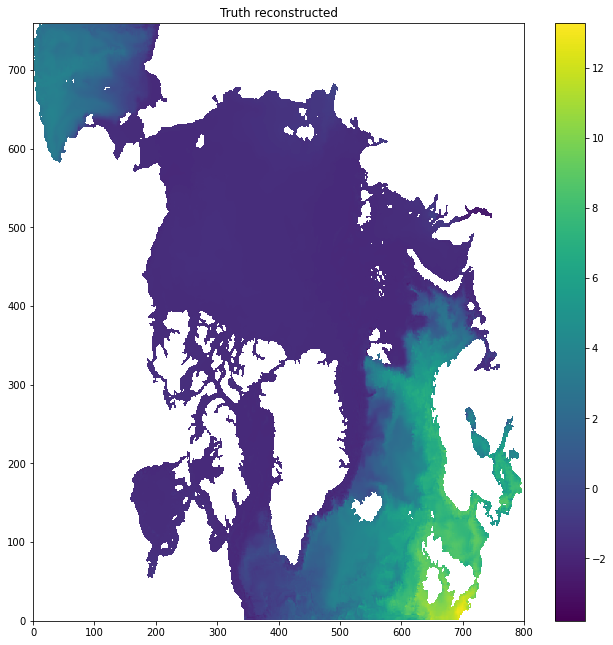

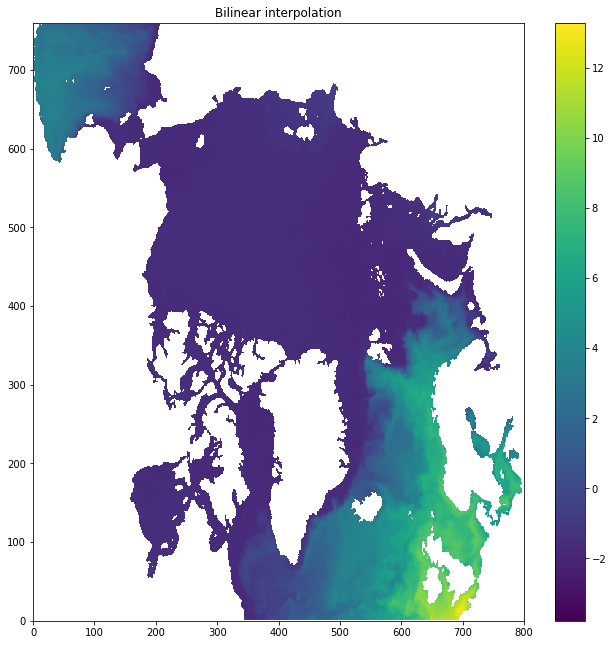

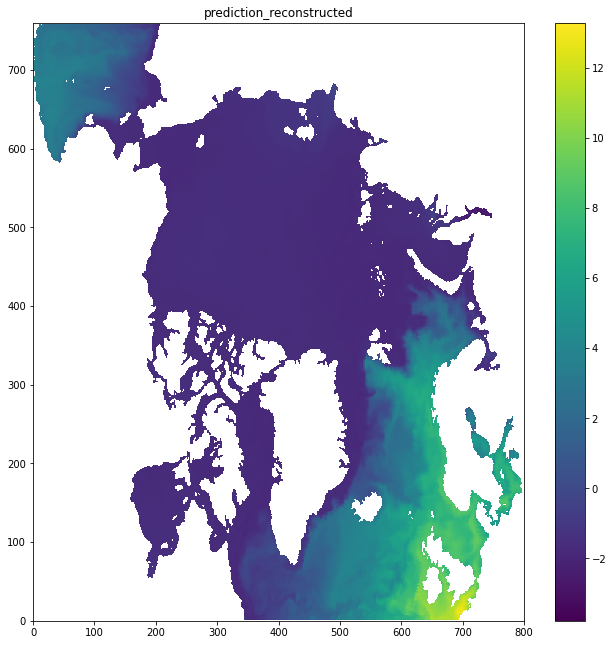

In [24]:
Truth_reconstructed = X+y
plot_fld('Truth reconstructed', Truth_reconstructed)
plot_fld('Bilinear interpolation',X,np.max(Truth_reconstructed),np.min(Truth_reconstructed))
plot_fld('prediction_reconstructed',prediction_reconstructed,np.max(Truth_reconstructed),np.min(Truth_reconstructed))

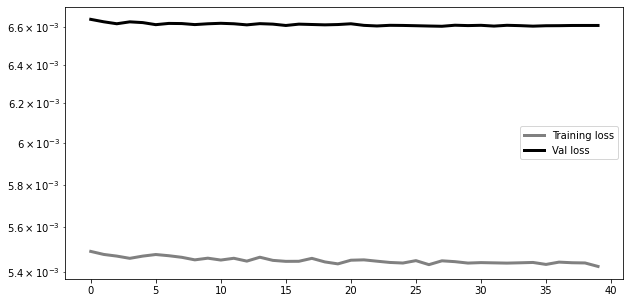

In [25]:
model_history = pickle.load(open(file_model_training_history,'rb'))
fig, ax = plt.subplots(figsize=(10,5))
ax.semilogy(model_history['loss'], color='gray', linewidth=3, label='Training loss')
ax.semilogy(model_history['val_loss'], color='black', linewidth=3, label='Val loss')

ax.legend()

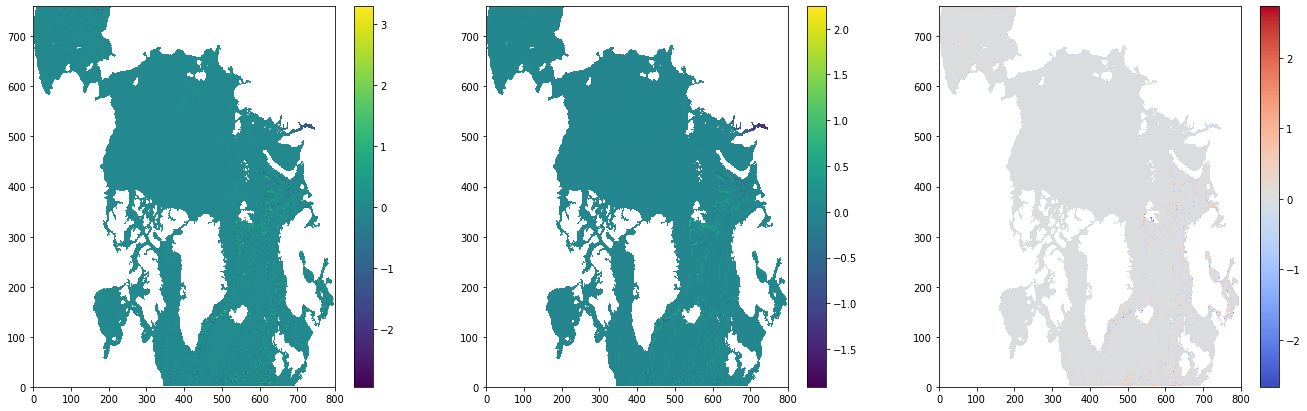

In [26]:
fig, ax = plt.subplots(ncols=3, figsize=(23,7))
c0 = ax[0].pcolormesh(y)
c1 = ax[1].pcolormesh(predict)
c2 = ax[2].pcolormesh((predict-y),cmap=plt.get_cmap('coolwarm'))
plt.colorbar(c0, ax=ax[0])
plt.colorbar(c1, ax=ax[1])
plt.colorbar(c2, ax=ax[2])

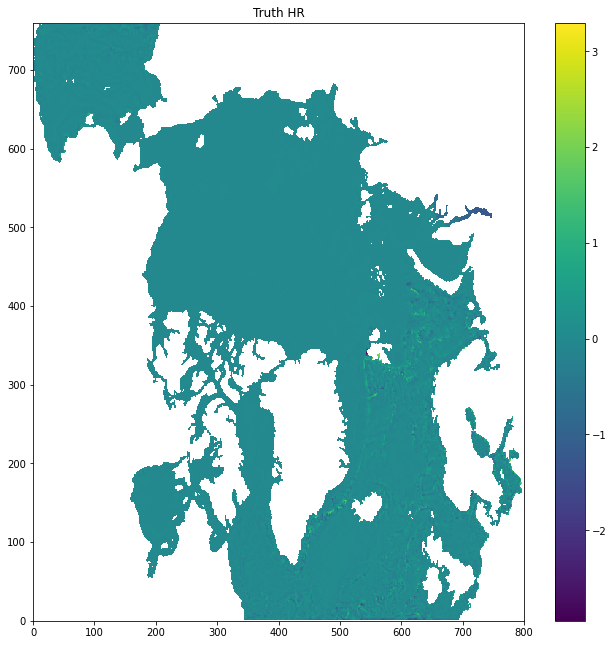

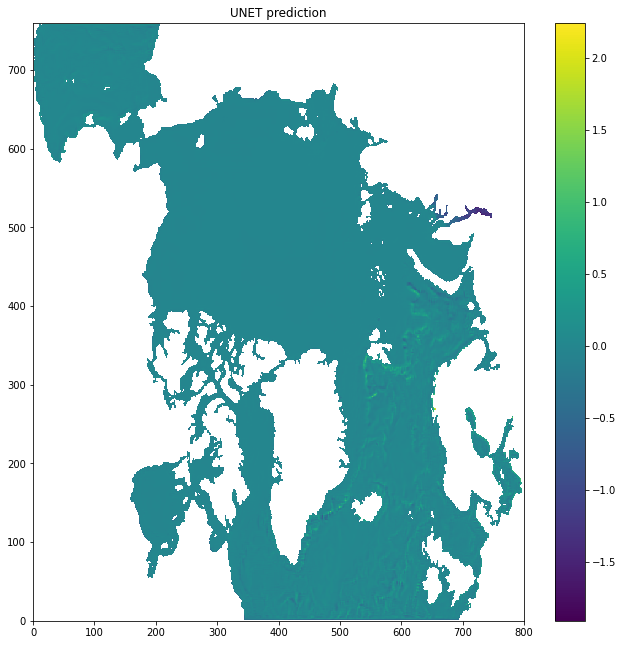

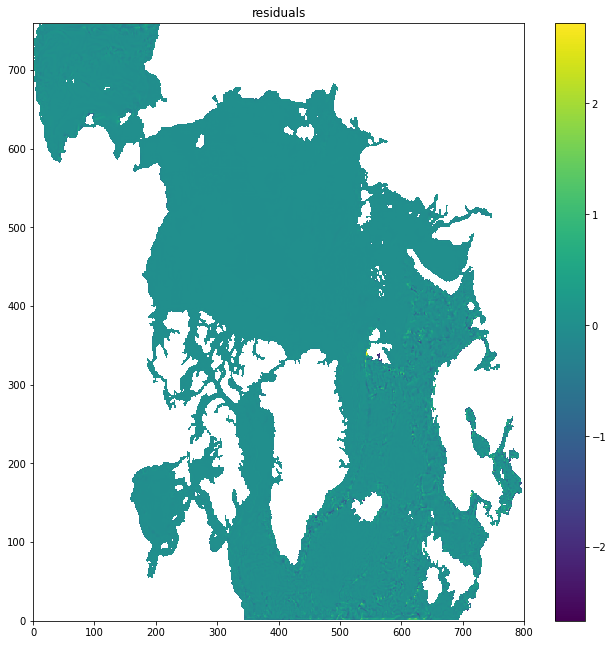

In [27]:
plot_fld('Truth HR',y)
maxval = np.max(y)
minval = np.min(y)
plot_fld('UNET prediction',predict)
plot_fld('residuals',predict-y)

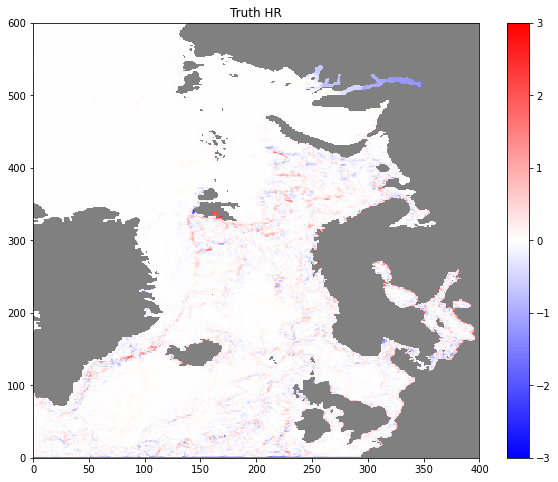

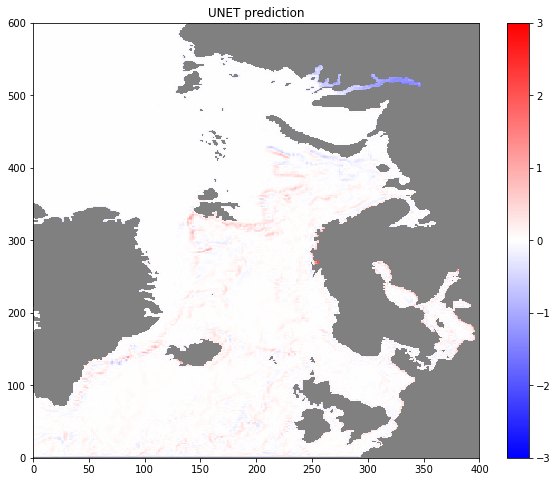

In [32]:
plot_res('Truth HR', y[0:600,400:800], 3)
plot_res('UNET prediction', predict[0:600,400:800], 3) #np.max(y), np.min(y))

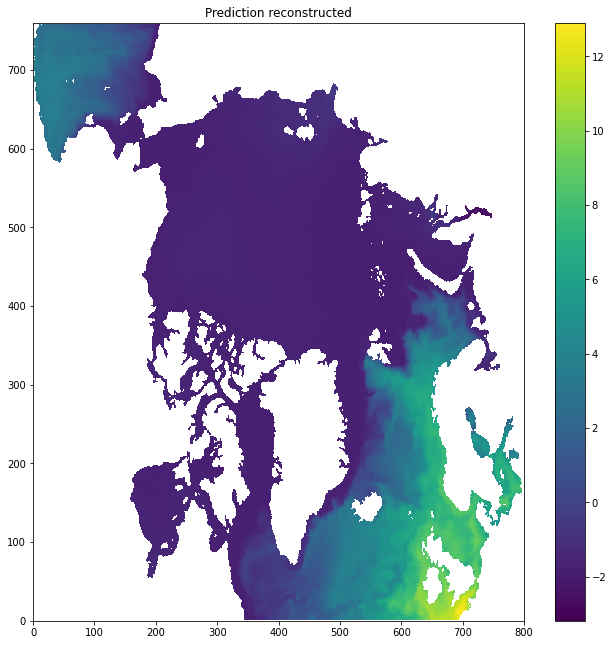

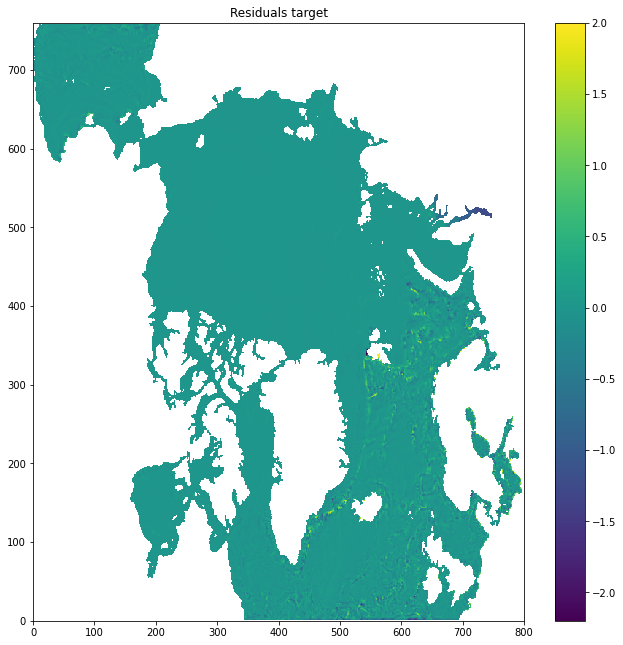

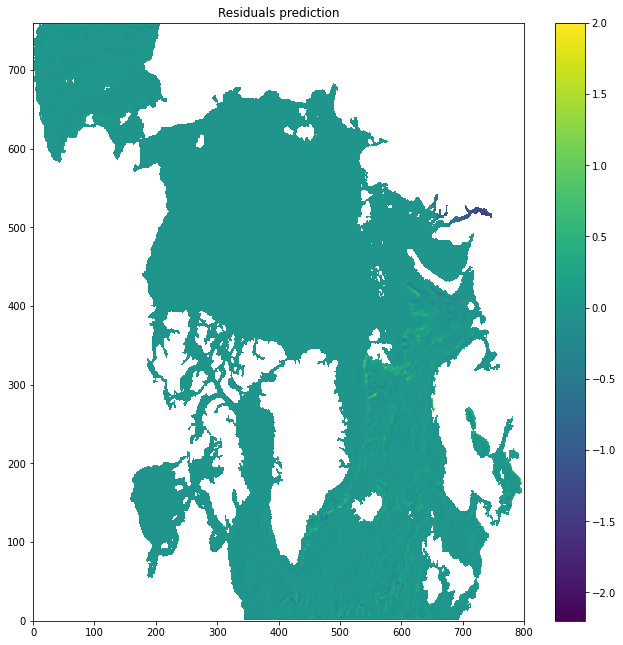

In [29]:
plot_fld('Prediction reconstructed',prediction_reconstructed)
plot_fld('Residuals target', y, -2, 2)#, 2.5, -4)
plot_fld('Residuals prediction', predict, -2, 2)#, 2.5, -4)

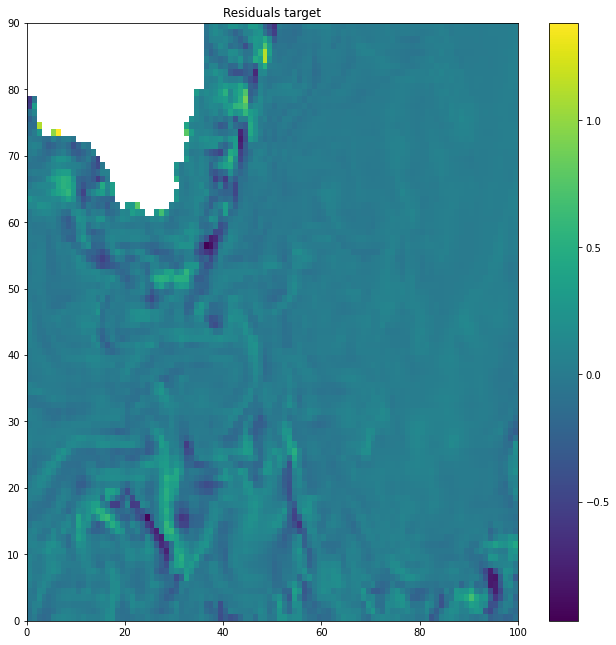

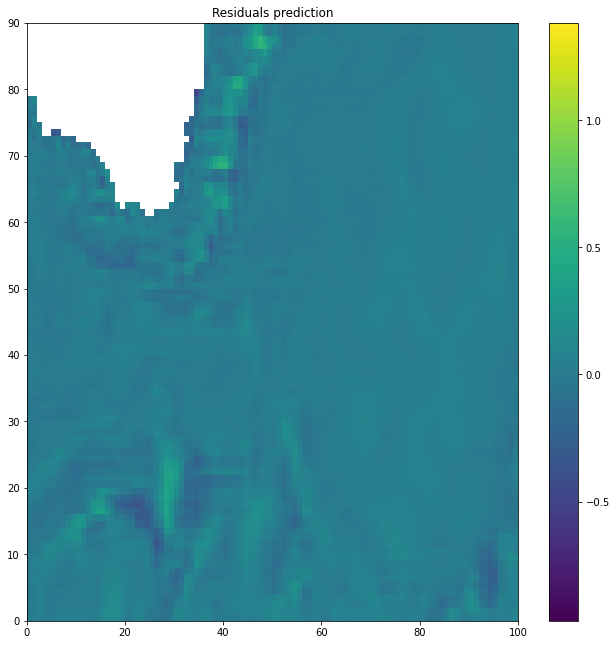

In [30]:
y_crop = y[10:100,400:500]
predict_crop = predict[10:100,400:500]
plot_fld('Residuals target', y_crop)#, 2.5, -4)
plot_fld('Residuals prediction', predict_crop, np.max(y_crop), np.min(y_crop))#, 2.5, -4)

## Error comparison with interpolation

##### For one field

mse upsample 0.02444275621981621
mse unet 0.015664951161899452
mae upsample 0.06247677129175146
mae unet 0.05656752551329172


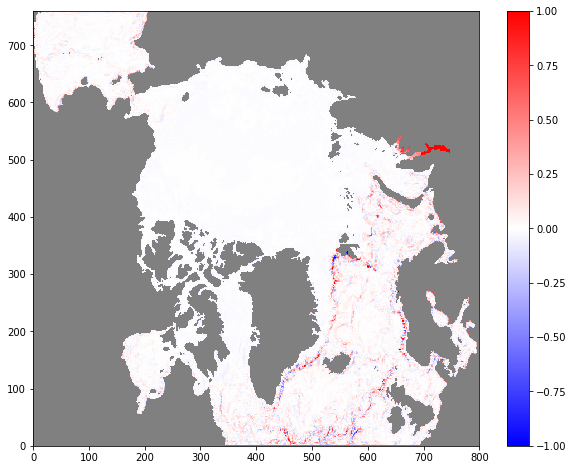

In [19]:
# Compute bias
bias = np.mean(y) - np.mean(predict)
print('Bias:', bias)

# MSE on unnormalized images
mse_upsample = np.mean(np.square(y)) # truth - LR_upsampled = truth - X = y
mse_unet = np.mean(np.square(y - predict)) # truth - prediction_reconstructed = y + X - (pred + X) = y - pred
print('mse upsample', mse_upsample)
print('mse unet', mse_unet)
#psnr_upsample = 10*np.log(255**2/mse_upsample)
#psnr_unet = 10*np.log(255**2/mse_unet)
#print('psnr upsample', psnr_upsample)
#print('psnr unet', psnr_unet)

# MAE on unnormalized images
mae_upsample = np.mean(np.abs(y))
mae_unet = np.mean(np.abs(y - predict))
print('mae upsample', mae_upsample)
print('mae unet', mae_unet)

#RMSE MAP
RMSE_MAP_upsample = np.sqrt(np.square(y))
RMSE_MAP_unet = np.sqrt(np.square(y - predict))
RMSE_MAP = RMSE_MAP_upsample - RMSE_MAP_unet
plot_res('',RMSE_MAP,1)

In [20]:
# Get the normalized images
target_no = 0
target_name, target_layer = extract_name_and_number(list_targets[target_no])
target_layer = int(target_layer)
predict = predict_batch[0,:,:,target_no]
predict = predict[0:760,:]
X_batch, y_batch = test_generator[0] ## True data
X = X_batch[0,...,target_no] ## first 0 -> sample number in the batch ... last 0 -> predictor number
y = y_batch[0,...,target_no]
X = X[0:760,:]
y = y[0:760,:]

# Impose masks
tp5mask = np.load(os.path.join(paths["data_residuals"],'tp5mask.npy') )
y = np.ma.masked_array(y,tp5mask)
predict = np.ma.masked_array(predict,tp5mask)
X = np.ma.masked_array(X,tp5mask)

truth = y + X
prediction_reconstructed = predict + X

# SSIM

# Turn into tf.tensor and add a 3rd dimension to use the tf.ssim function
# NB: WHEN CONVERTING A MASK ARRAY TO TF_TENSOR, THE MASK BECOME 0
tf_truth = tf.convert_to_tensor(truth, dtype=tf.float32)
tf_prediction_reconstructed = tf.convert_to_tensor(prediction_reconstructed, dtype=tf.float32)
tf_X = tf.convert_to_tensor(X, dtype=tf.float32)

tf_truth = tf_truth[..., tf.newaxis] 
tf_prediction_reconstructed = tf_prediction_reconstructed[..., tf.newaxis] 
tf_X = tf_X[..., tf.newaxis] 

ssim_upsample = tf.image.ssim_multiscale(tf_truth, tf_X, max_val=1.0)
ssim_unet = tf.image.ssim_multiscale(tf_truth, tf_prediction_reconstructed, max_val=1.0)
print('ssim upsample', ssim_upsample)
print('ssim unet', ssim_unet)

# RMSE on normalized images
mse_upsample = np.mean(np.square(y)) # truth - LR_upsampled = truth - X = y
mse_unet = np.mean(np.square(y - predict)) # truth - prediction_reconstructed = y + X - (pred + X) = y - pred
print('mse upsample', mse_upsample)
print('mse unet', mse_unet)
#psnr_upsample = 10*np.log(255**2/mse_upsample)
#psnr_unet = 10*np.log(255**2/mse_unet)
#print('psnr upsample', psnr_upsample)
#print('psnr unet', psnr_unet)

# MAE on normalized images
mae_upsample = np.mean(np.abs(y))
mae_unet = np.mean(np.abs(y - predict))
print('mae upsample', mae_upsample)
print('mae unet', mae_unet)

ssim upsample tf.Tensor(0.6325834, shape=(), dtype=float32)
ssim unet tf.Tensor(0.5345319, shape=(), dtype=float32)
mse upsample 0.2039894662810027
mse unet 1.6158485235881708e-05
mae upsample 0.4516231430746874
mae unet 0.001852359560623984


In [ ]:
correlation_coefficient = np.corrcoef(prediction_reconstructed, truth)
#correlation_coefficient = np.corrcoef(prediction_reconstructed.flatten(), truth.flatten())

print("Correlation Coefficient:")
print(correlation_coefficient)

##### Mean for all Test images

In [52]:
predict_all = unet_model.predict(test_generator) #test_generator['batch_number'][number of the sample in the batch']
predict = predict_all[:,0:-8,:,:]
print(predict_all.shape)
print(predict.shape)

(52, 768, 800, 1)
(52, 760, 800, 1)


###### RMSE

In [62]:
total_mse_upsampled = np.zeros(len(list_targets))
total_mse_prediction = np.zeros(len(list_targets))
total_rrmse_upsampled = np.zeros(len(list_targets))
total_rrmse_prediction = np.zeros(len(list_targets))
batch_size = model_params["batch_size"]
filenames = test_generator.get_filenames()

for target_number in range (len(list_targets)):
    # Get the field name and layer number for denormalization
    name, number = extract_name_and_number(list_targets[target_number])
    number = int(number)
    #print(name,number)
    
    for i in range(len(test_generator)): # for each batch
        # Extract X and Y from the tuple
        X_i, Y_i = test_generator[i]
        predict_batch = unet_model.predict(test_generator[i][0])

        for sample_j in range(batch_size): # for each sample in batch i
            X_ij = X_i[sample_j, 0:-8, :, target_number]
            Y_ij = Y_i[sample_j, 0:-8, :, target_number]
        
            X_ij = denormalize(standard_LR_upsampled, name, number, X_ij)
            X_ij = np.ma.masked_array(X_ij,tp5mask)

            Y_ij = denormalize(standard_res, name, number, Y_ij)
            Y_ij = np.ma.masked_array(Y_ij,tp5mask)

            truth_ij = Y_ij + X_ij

            predict_ij = predict_batch[sample_j,0:-8,:,target_number]
            #predict_ij = predict[batch_size*i + sample_j,:,:,target_number]
            predict_ij = denormalize(standard_res, name, number, predict_ij)
            predict_ij = np.ma.masked_array(predict_ij,tp5mask)

            predict_reconstructed_ij = predict_ij + X_ij

            mse_upsampled = np.mean((Y_ij)**2)
            mse_prediction = np.mean((truth_ij - predict_reconstructed_ij)**2)
            
            rrmse_upsampled = np.sqrt( np.mean((Y_ij)**2)/np.sum(np.square(X_ij)) )
            rrmse_prediction = np.sqrt(np.mean((truth_ij - predict_reconstructed_ij)**2)/np.sum(np.square(predict_reconstructed_ij)))

            total_mse_upsampled[target_number] += mse_upsampled
            total_mse_prediction[target_number] += mse_prediction
    
            total_rrmse_upsampled[target_number] += rrmse_upsampled
            total_rrmse_prediction[target_number] += rrmse_prediction

mean_mse_upsampled = total_mse_upsampled / len(dates_test) # divide by the number of dates in the test set
mean_mse_prediction = total_mse_prediction / len(dates_test) # divide by the number of dates in the test set

print(f'MSE of all LR_upsampled values: {mean_mse_upsampled}')
print(f'MSE of all predicted values: {mean_mse_prediction}')

mean_rrmse_upsampled = total_rrmse_upsampled / len(dates_test)
mean_rrmse_prediction = total_rrmse_prediction / len(dates_test)

print(f'RRMSE of all LR_upsampled values: {mean_rrmse_upsampled}')
print(f'RRMSE of all predicted values: {mean_rrmse_prediction}')

MSE of all LR_upsampled values: [0.05902528]
MSE of all predicted values: [0.0352215]
RRMSE of all LR_upsampled values: [9.18545277e-05]
RRMSE of all predicted values: [7.14352167e-05]


###### SSIM

In [65]:
total_ssim_upsampled = np.zeros(len(list_targets))
total_ssim_prediction = np.zeros(len(list_targets))

batch_size = model_params["batch_size"]
filenames = test_generator.get_filenames()

for target_number in range (len(list_targets)):
    # Get the field name and layer number for denormalization
    name, number = extract_name_and_number(list_targets[target_number])
    number = int(number)
    #print(name,number)
    
    for i in range(len(test_generator)): # for each batch
        # Extract X and Y from the tuple
        X_i, Y_i = test_generator[i]
        predict_batch = unet_model.predict(test_generator[i][0])

        for sample_j in range(batch_size): # for each sample in batch i
            X_ij = X_i[sample_j, 0:-8, :, target_number]
            Y_ij = Y_i[sample_j, 0:-8, :, target_number]
        
            X_ij = np.ma.masked_array(X_ij,tp5mask)
            Y_ij = np.ma.masked_array(Y_ij,tp5mask)
            truth_ij = Y_ij + X_ij
            
            tf_Xij = tf.convert_to_tensor(X_ij, dtype=tf.float32)
            tf_Xij = tf_Xij[..., tf.newaxis]

            tf_truth = tf.convert_to_tensor(truth_ij, dtype=tf.float32)
            tf_truth = tf_truth[..., tf.newaxis] 

            predict_ij = predict_batch[sample_j,0:-8,:,target_number]
            predict_ij = np.ma.masked_array(predict_ij,tp5mask)

            predict_reconstructed_ij = predict_ij + X_ij
            tf_prediction_reconstructed = tf.convert_to_tensor(predict_reconstructed_ij, dtype=tf.float32)
            tf_prediction_reconstructed = tf_prediction_reconstructed[..., tf.newaxis] 

            ssim_upsample = tf.image.ssim_multiscale(tf_truth, tf_Xij, max_val=1.0)
            ssim_unet = tf.image.ssim_multiscale(tf_truth, tf_prediction_reconstructed, max_val=1.0)

            total_ssim_upsampled[target_number] += ssim_upsample
            total_ssim_prediction[target_number] += ssim_unet

mean_ssim_upsampled = total_ssim_upsampled / len(dates_test) # divide by the number of dates in the test set
mean_ssim_prediction = total_ssim_prediction / len(dates_test) # divide by the number of dates in the test set

print(f'Mean of SSIM of all LR_upsampled values: {mean_ssim_upsampled}')
print(f'Mean of SSIM of all predicted values: {mean_ssim_prediction}')

Mean of SSIM of all LR_upsampled values: [0.66746807]
Mean of SSIM of all predicted values: [0.52860509]


## Visualization of training data

In [25]:
var_name = 'temp'
layer_number = 1

date_min_train = '1995_008'
date_max_train = '1995_127'
date_min_valid = '2012_008'
date_max_valid = '2015_127'

days_range = 7 # number of days between two restart
dates_learning = generate_dates(date_min_train, date_max_train, days_range)

X_training = []
y_training = []
for dates in dates_learning:
    file_ID = os.path.join(paths["data_LR_upsampled"],f"restart.{dates}_00_0000.a")
    ab_file = abfile.ABFileRestart(file_ID,"r",idm=800,jdm=760)
    var_data = ab_file.read_field(var_name,layer_number,1)
    X_training.append(var_data)
    ab_file.close
    file_ID = os.path.join(paths["data_residuals"],f"restart.{dates}_00_0000.a")
    ab_file = abfile.ABFileRestart(file_ID,"r",idm=800,jdm=760)
    var_data = ab_file.read_field(var_name,layer_number,1)
    y_training.append(var_data)
    ab_file.close

In [23]:
var_name = 'iceumask'
layer_number = 1

date_min_train = '1995_008'
date_max_train = '1995_127'
date_min_valid = '2012_008'
date_max_valid = '2015_127'

days_range = 7 # number of days between two restart
dates_learning = generate_dates(date_min_train, date_max_train, days_range)

X_training = []
y_training = []
for dates in dates_learning: 
    file_ID = os.path.join(paths["data_LR_upsampled"],f"iced.{dates}_00_0000.nc")
    nc_file = Dataset(file_ID, 'r')
    var_data = nc_file.variables[var_name][:].data
    var_data = np.where(var_data > 0, 0, 1)
    var_data = 1 - var_data
    X_training.append(var_data)
    nc_file.close
    file_ID = os.path.join(paths["data_residuals"],f"iced.{dates}_00_0000.nc")
    nc_file = Dataset(file_ID, 'r')
    var_data = nc_file.variables[var_name][:].data
    var_data = np.where((var_data < 0.1) & (var_data >-0.1), 0, var_data)
    var_data = np.where(var_data > 0.1, 1, var_data)
    var_data = np.where(var_data < -0.1, -1, var_data)
    y_training.append(var_data)
    nc_file.close

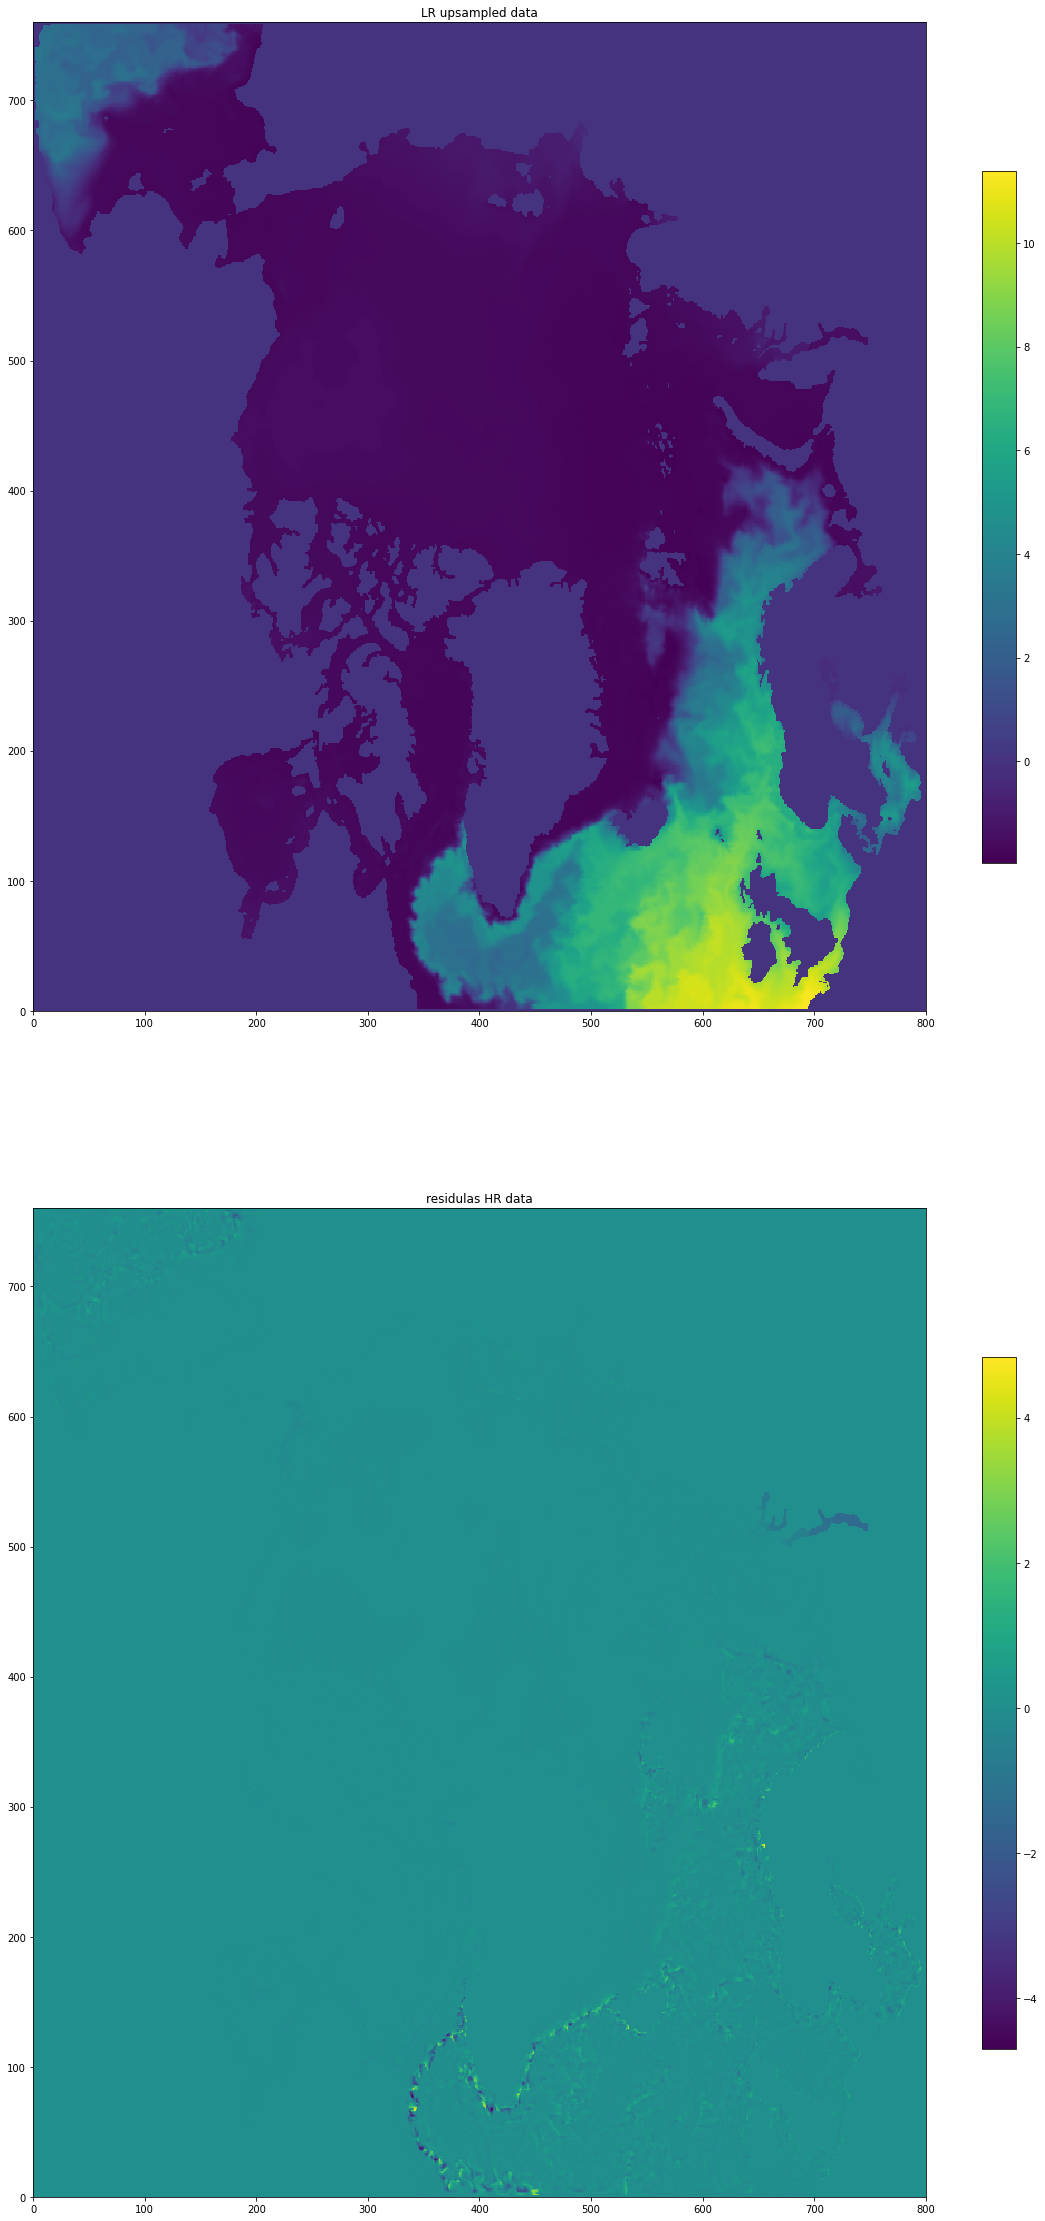

In [26]:
nb_sample = 5
X = X_training[nb_sample]
y = y_training[nb_sample]
fig, ax = plt.subplots(nrows = 2, figsize=(20, 40))  

c0 = ax[0].pcolormesh(X)
c1 = ax[1].pcolormesh(y)

colorbar0 = plt.colorbar(c0, ax=ax[0], shrink=0.7)
colorbar1 = plt.colorbar(c1, ax=ax[1], shrink=0.7)

ax[0].set_title('LR upsampled data')
ax[1].set_title('residulas HR data')

plt.show()


## Spectral Power

In [17]:
import scipy.stats as stats

def power_spectrum(xx):
    """
    https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
    """
    
    ny,nx = xx.shape

    npix = min(nx, ny)
    fourier_image = np.fft.fftn(xx)
    fourier_amplitudes = np.abs(fourier_image)**2
    #By default, the wave vectors are given as a fraction of 1, by multiplying with the total number of pixels, we convert them to a pixel frequency.
    kfreqx = np.fft.fftfreq(nx) * nx
    kfreqy = np.fft.fftfreq(ny) * ny
    kfreq2D = np.meshgrid(kfreqy,kfreqx)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm=knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    #fourier_amplitudes=fourier_amplitudes.reshape(n,-1)
    #fourier_amplitudes_mean = np.mean(fourier_amplitudes,axis=0)
    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic ="mean",
                                     bins = kbins)
    #Abins *= 4. * np.pi / 3. * (kbins[1:]**3 - kbins[:-1]**3)
    #Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

white_noise = tf.random.normal(shape=(400,400))

In [18]:
#HRtmp = abfile.ABFileRestart('/mnt/redda-ns2993k/Antoine/Betzy/data/HR/restart.1995_036_00_0000.a',"r",idm=800,jdm=760)
#LRtmp = abfile.ABFileRestart('/mnt/redda-ns2993k/Antoine/Betzy/data/LR/restart.1995_036_00_0000.a',"r",idm=400,jdm=380)
#fieldHR = HRtmp.read_field('temp',1,1)
#fieldLR = LRtmp.read_field('temp',1,1)

tp5mask = np.load('/mnt/redda-ns2993k/Antoine/Betzy/data/residuals/tp5mask.npy')
tp2mask = np.load('/mnt/redda-ns2993k/Antoine/Betzy/data/LR/tp2mask.npy')

from scipy.interpolate import RegularGridInterpolator
def downsample_array(original_array, target_shape=(380,400)):
    n_rows, n_cols = original_array.shape
    x = np.linspace(0, 759, n_rows)
    y = np.linspace(0, 799, n_cols)
    interp = RegularGridInterpolator((x, y), original_array, method='nearest', bounds_error=False, fill_value=None)
    x_new = np.linspace(0, 759, target_shape[0])
    y_new = np.linspace(0, 799, target_shape[1])
    xg_new, yg_new = np.meshgrid(x_new, y_new, indexing='ij')
    return interp((xg_new, yg_new))

from scipy.spatial import cKDTree
def downsampling(original_array):
    fieldData = original_array.copy()
    fieldData = fieldData.data
    fieldData[tp5mask] = np.nan
    fieldDS = downsample_array(fieldData)
    fieldDS[tp2mask] = 0
    nan_indices = np.isnan(fieldDS.data)
    coordinates = np.column_stack(np.where(np.logical_and(~tp2mask, ~nan_indices)))
    tree = cKDTree(coordinates)
    nearest_indices = tree.query(np.column_stack(np.where(nan_indices)))[1]
    nearest_values = fieldDS[coordinates[nearest_indices][:, 0], coordinates[nearest_indices][:, 1]]
    fieldDS[nan_indices] = nearest_values
    return fieldDS

NN_DS = downsampling(prediction_reconstructed)
fieldLR = downsampling(X)

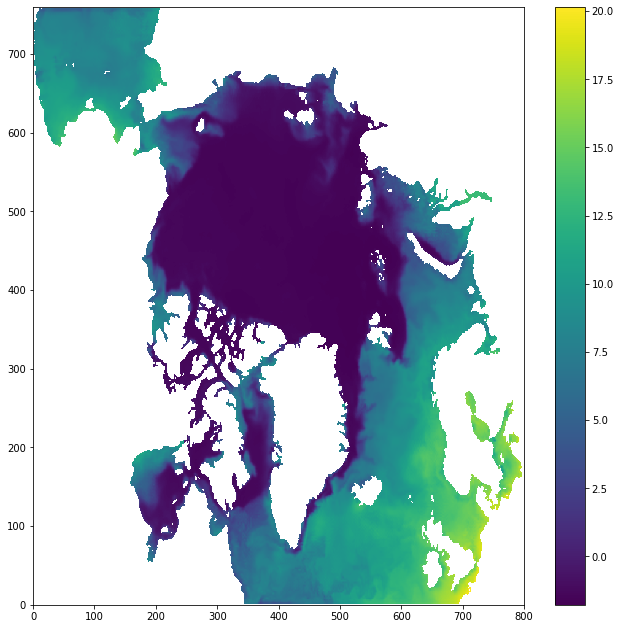

In [19]:
plot_fld('',X)

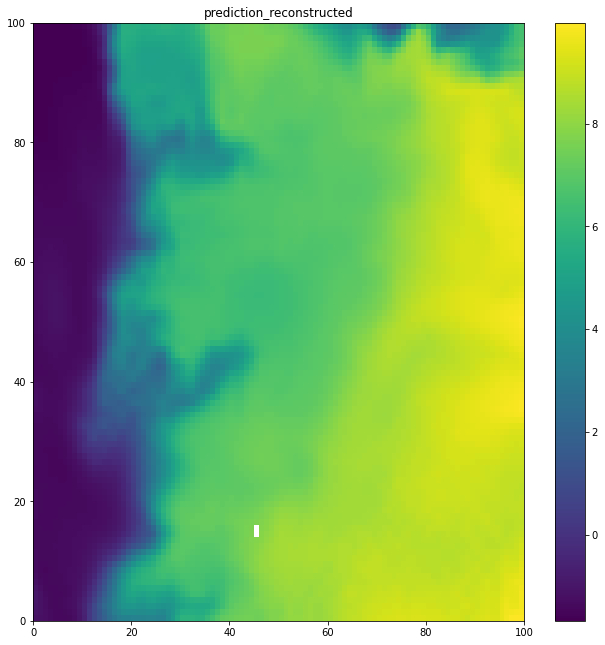

In [28]:
range_rowsHR = slice(210, 310)
range_colsHR = slice(515, 615)
range_rowsLR = slice(range_rowsHR.start // 2, range_rowsHR.stop // 2)
range_colsLR = slice(range_colsHR.start // 2, range_colsHR.stop // 2)

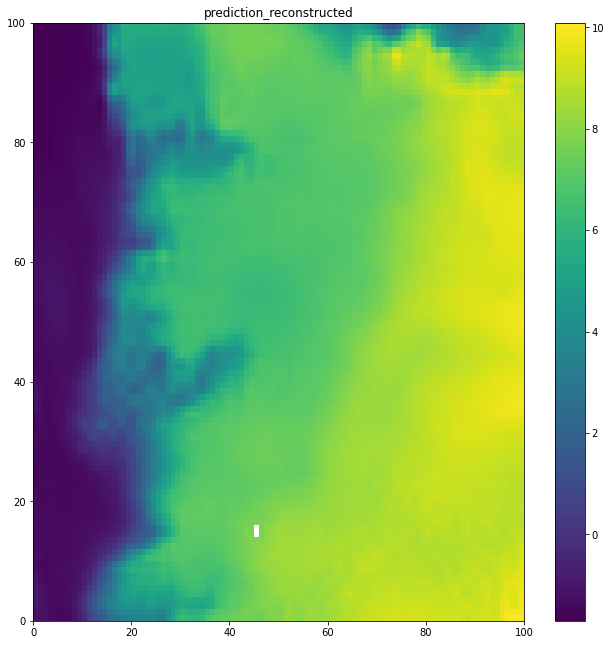

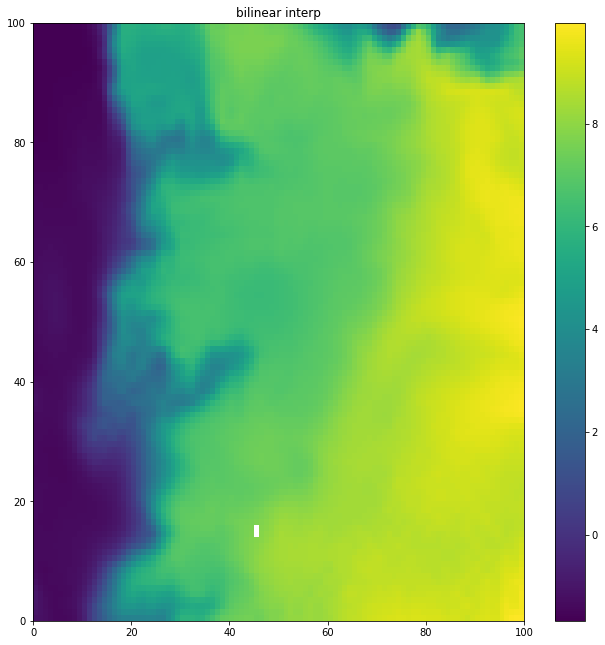

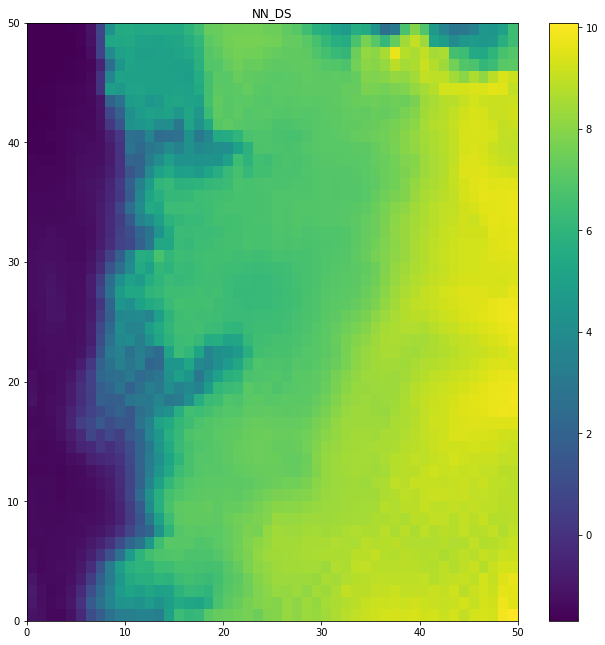

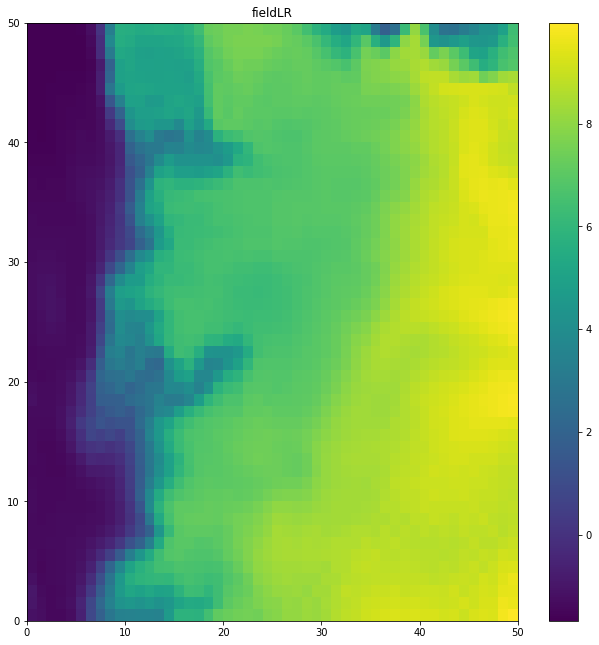

In [29]:
plot_fld('prediction_reconstructed',prediction_reconstructed[range_rowsHR,range_colsHR])
plot_fld('bilinear interp',X[range_rowsHR,range_colsHR])
plot_fld('NN_DS',NN_DS[range_rowsLR,range_colsLR])
plot_fld('fieldLR',fieldLR[range_rowsLR,range_colsLR])
#plot_fld('',white_noise)

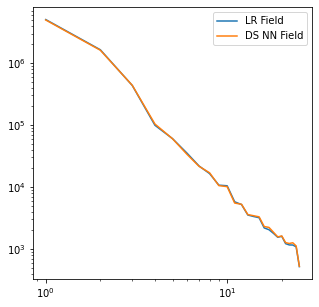

In [32]:
#kwhite, Awhite = power_spectrum(white_noise[:400,:400])
klr, Alr = power_spectrum(fieldLR[range_rowsLR,range_colsLR])
kds, Ads = power_spectrum(NN_DS[range_rowsLR,range_colsLR])

fig, ax = plt.subplots(figsize=(5,5))

#ax.loglog(kwhite, Awhite)
ax.loglog(klr, Alr, label='LR Field')
ax.loglog(kds, Ads, label='DS NN Field')
ax.legend()

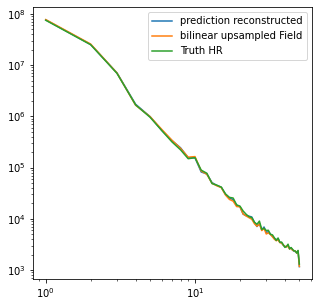

In [31]:
khr, Ahr = power_spectrum(prediction_reconstructed[range_rowsHR,range_colsHR])
ktruth, Atruth = power_spectrum(Truth_reconstructed[range_rowsHR,range_colsHR])
kbilinear, Abilinear = power_spectrum(X[range_rowsHR,range_colsHR])

fig, ax = plt.subplots(figsize=(5,5))

ax.loglog(khr, Ahr, label='prediction reconstructed')
ax.loglog(kbilinear, Abilinear, label='bilinear upsampled Field')
ax.loglog(ktruth, Atruth, label='Truth HR')
ax.legend()

## Vorticity

In [ ]:
def compute_vorticity(u, v):
    zeta = (np.roll(v, -1, axis=1) - np.roll(v, 1, axis=1) - np.roll(u, -1, axis=0) + np.roll(u, 1, axis=0)) / 2.0
    return zeta

## Attention heat map

In [18]:
model_gate = tf.keras.models.Model(inputs=unet_model.input, outputs=unet_model.get_layer("Attention_weights_4").output)
gpredict = model_gate.predict(test_generator[0][0])

(4, 768, 800, 32)


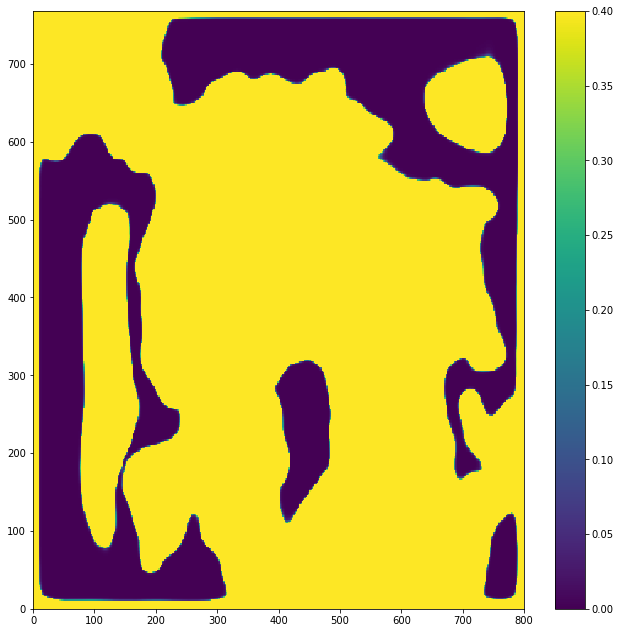

In [19]:
print(gpredict.shape)
i = 0
gprediction = gpredict[0,:,:,i]
plot_fld('',gprediction,0.4,0)

## Write new restart

In [17]:
index0 = test_generator.indexes[0]
date0 = test_generator.get_filename_from_ID(index0)
date0 = '2015_074'

In [21]:
from scipy.interpolate import RegularGridInterpolator

def downsample_array(original_array, target_shape=(380,400)):
    n_rows, n_cols = original_array.shape
    x = np.linspace(0, 759, n_rows)
    y = np.linspace(0, 799, n_cols)
    interp = RegularGridInterpolator((x, y), original_array, method='nearest', bounds_error=False, fill_value=None)
    x_new = np.linspace(0, 759, target_shape[0])
    y_new = np.linspace(0, 799, target_shape[1])
    xg_new, yg_new = np.meshgrid(x_new, y_new, indexing='ij')
    return interp((xg_new, yg_new))

tp2mask = np.load('/mnt/redda-ns2993k/Antoine/Betzy/data/LR/tp2mask.npy')
tp5mask_bool = tp5mask.astype(bool)
tp2mask_bool = tp2mask.astype(bool)

Initial_restart_file = '/mnt/redda-ns2993k/Antoine/Betzy/data/LR/restart.' + date0 + '_00_0000.a'
Initial_restart = abfile.ABFileRestart(Initial_restart_file,"r",idm=400,jdm=380)

New_restart_file = '/home/julaja/Antoine/New_restarts/restart.' + date0 + '_00_0000.a'
New_restart = abfile.ABFileRestart(New_restart_file,"w",idm=400,jdm=380)
New_restart.write_header(23, Initial_restart._iversn, Initial_restart._yrflag, Initial_restart._sigver, Initial_restart._nstep, Initial_restart._dtime, Initial_restart._thbase)

for keys in sorted( Initial_restart.fields.keys() ) :
    fieldname = Initial_restart.fields[keys]["field"]
    k         = Initial_restart.fields[keys]["k"]
    t         = 1
    field     = Initial_restart.read_field(fieldname,k,t)
    
    if fieldname == 'tempqqq' and k == 1:
        fieldData = prediction_reconstructed.data
        fieldData[tp5mask] = np.nan
        fieldDS = downsample_array(fieldData)

        fieldDS[tp2mask] = 0

        # Find the indices where NaN values occur
        nan_indices = np.isnan(fieldDS.data)

        # Coordinates of the non nan fill in values
        coordinates = np.column_stack(np.where(np.logical_and(~tp2mask, ~nan_indices)))
        tree = cKDTree(coordinates)
        # nearest indices for each nan
        nearest_indices = tree.query(np.column_stack(np.where(nan_indices)))[1]
        # according values
        nearest_values = fieldDS[coordinates[nearest_indices][:, 0], coordinates[nearest_indices][:, 1]]

        fieldDS[nan_indices] = nearest_values
        New_restart.write_field(fieldDS,True,'temp',1,1)
    else:
        New_restart.write_field(field,True,fieldname,k,t)

New_restart.close()
Initial_restart.close()

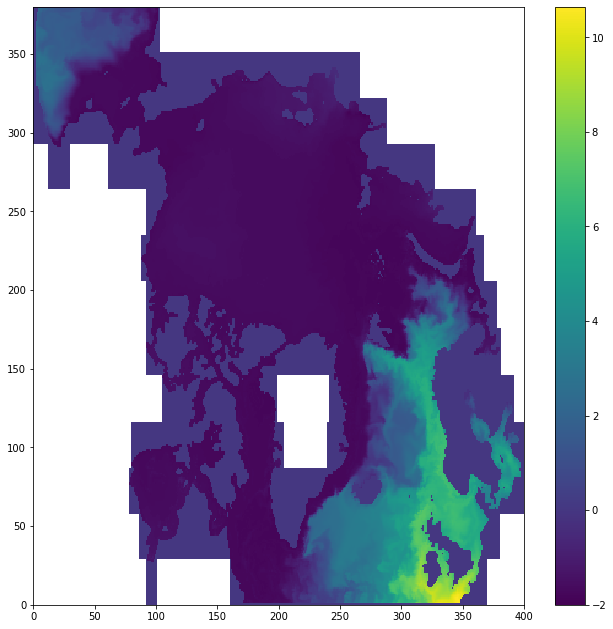

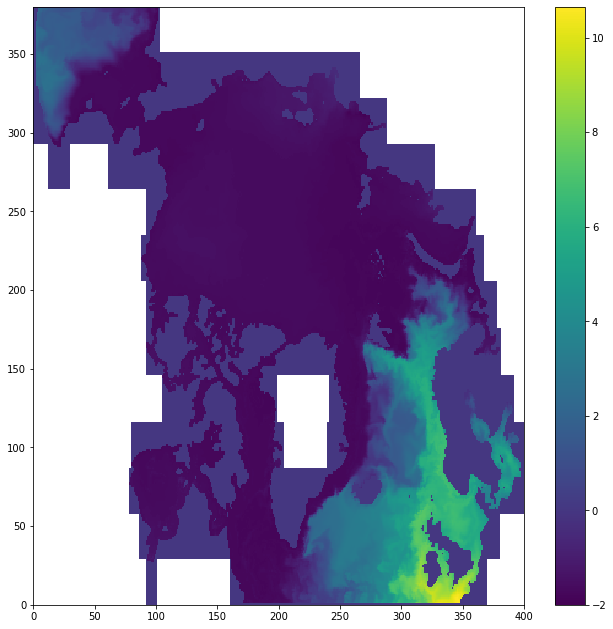

In [22]:
New_restart_file = '/home/julaja/Antoine/New_restarts/restart.' + date0 + '_00_0000.a'
New_restart = abfile.ABFileRestart(New_restart_file,"r",idm=400,jdm=380)
field1 = New_restart.read_field('temp',1,1)
plot_fld('',field1)

field2 = New_restart.read_field('temp',2,1)
plot_fld('',field2)

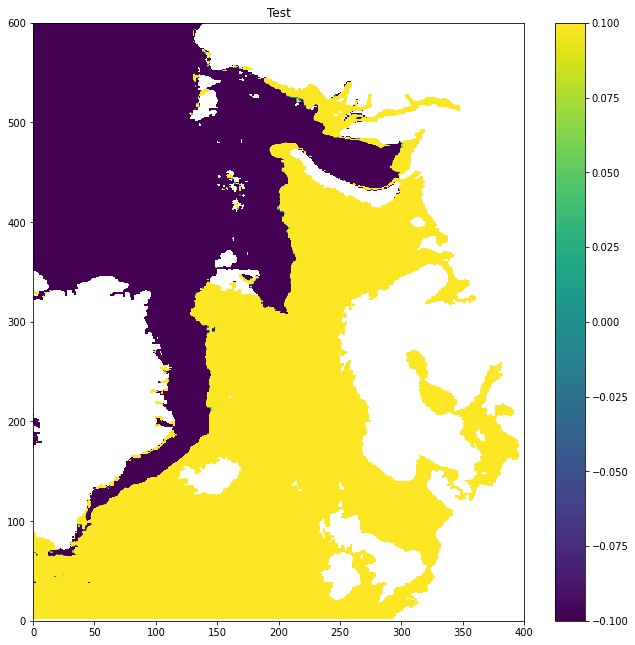

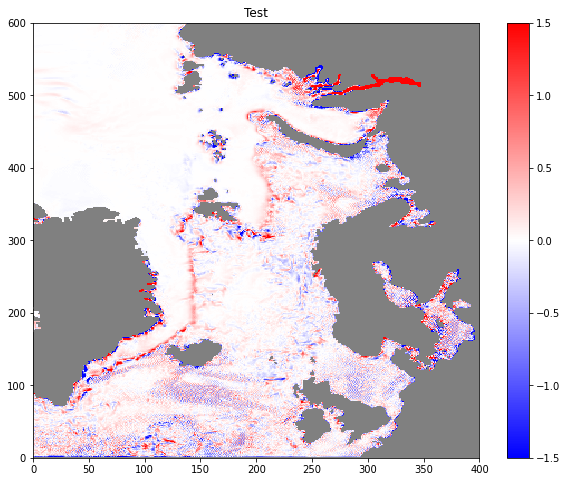

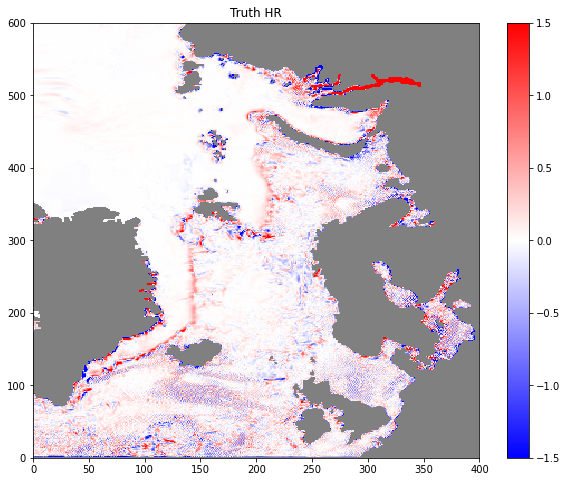

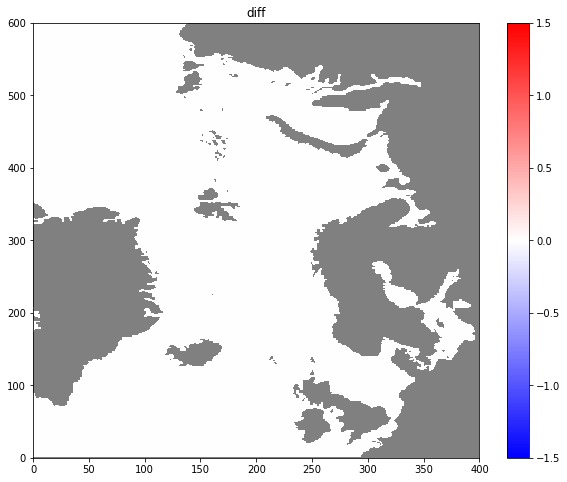

In [43]:
testtmp = abfile.ABFileRestart('/mnt/redda-ns2993k/Antoine/Betzy/data/residuals/restart.2015_165_00_0000.a',"r",idm=800,jdm=760)
testfield = testtmp.read_field('temp',1,1)
testfield = np.ma.masked_array(testfield,tp5mask)

plot_fld('Test', prediction_reconstructed[0:600,400:800] )

plot_res('Test', testfield[0:600,400:800], 1.5 )
plot_res('Truth HR', y[0:600,400:800], 1.5 )
plot_res('diff', y[0:600,400:800] - testfield[0:600,400:800], 1.5 )